# Introduction to Data science - Exercise 2

# Exercise 2: time series predictive model and evaluation

In [2733]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from IPython.display import display, Markdown

! pip install fbprophet
from fbprophet import Prophet;


# Importing the Data for Stations

In [2734]:
data_stations = pd.read_csv('example_sprit_cut_station.csv', delimiter = ';')

In [2735]:
# Visualizing the Data

data_stations.head()

,ID,VERSION,VERSION_TIME,NAME,BRAND,STREET,HOUSE_NUMBER,POST_CODE,PLACE,PUBLIC_HOLIDAY_IDENTIFIER,LAT,LNG
0,d37bee76-91b6-485a-b974-24f1b0d391fa,4,2015-01-09 10:26:15.000000,Aral Tankstelle,ARAL,An der Tagweide,2,76139,Karlsruhe,\N,49.020280,8.459429
1,51d4b652-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET MANNHEIM UNTERMUEHLAUSTRASSE 83,JET,UNTERMUEHLAUSTRASSE 83,\N,68169,MANNHEIM,\N,49.508962,8.467691
2,c7caf231-0e47-40db-92de-9349a2eb2bef,4,2014-09-26 13:24:57.000000,Aral Tankstelle,ARAL,Trippstadter Straße,69,67663,Kaiserslautern,\N,49.433754,7.757465
3,51d4b53b-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET KAISERSLAUTERN PARISER STR. 167,JET,PARISER STR. 167,\N,67655,KAISERSLAUTERN,\N,49.442200,7.748360
4,51d4b70f-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET GERMERSHEIM MUENCHENER STRASSE 12,JET,MUENCHENER STRASSE 12,\N,76726,GERMERSHEIM,\N,49.226800,8.374400


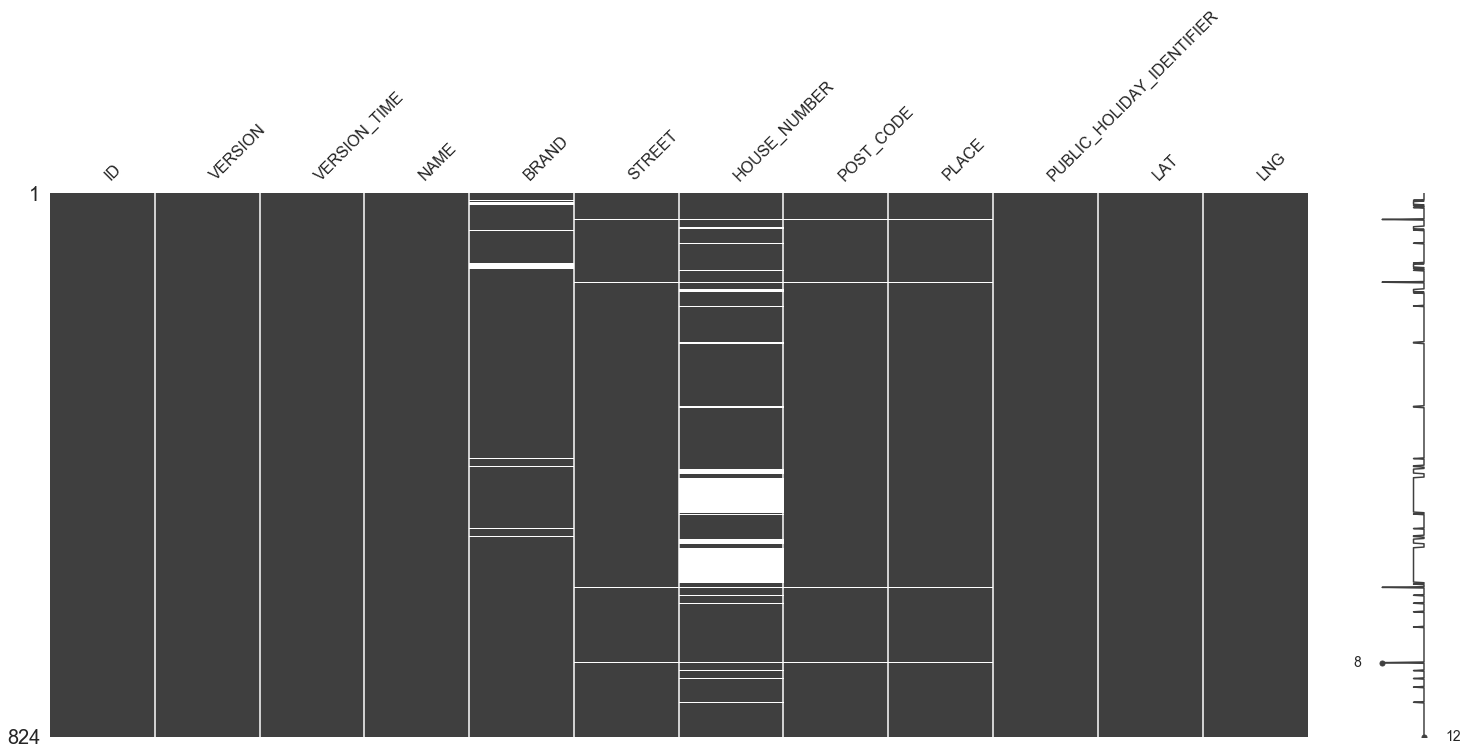

In [2736]:
# Visualizing missing entries

msno.matrix(data_stations)

# Data Cleaning Activity

In [2737]:
# Drop duplicate rows

data_stations.drop_duplicates(inplace=True)

In [2738]:
data_stations.shape

(412, 12)

In [2739]:
# Filling Place and Street COlumn

data_stations.update(data_stations[['STREET','PLACE']].fillna('Not Known'))
data_stations[['STREET','PLACE']] = data_stations[['STREET','PLACE']].replace('\\N','Not Known')

In [2740]:
#Droping Unwanted COlumns

data_stations.drop(['VERSION','VERSION_TIME','HOUSE_NUMBER','PUBLIC_HOLIDAY_IDENTIFIER'],inplace =True,axis=1)

In [2741]:
# Dropping the brand which is no more aktiv

data_stations=data_stations[data_stations.BRAND != 'nicht mehr aktiv']# Replacing invalid entries in Brands

In [2742]:
# Replacing invalid entries in Brands

data_stations.update(data_stations['BRAND'].fillna('NO BRAND'))
data_stations['BRAND']=data_stations['BRAND'].replace('\\N','NO BRAND')

In [2743]:
# Capitalizing letter of Brand and Name Column

data_stations['BRAND'] = data_stations.BRAND.str.upper()
data_stations['NAME'] = data_stations.NAME.str.upper()

In [2744]:
# Replacing blank values of BRAND with NAME

data_stations['BRAND']=np.where(data_stations['BRAND']=='NO BRAND', data_stations['NAME'],data_stations['BRAND'])

In [2745]:
# Replacing same brand names by a single name

replace_name = ['GLOBUS HANDELSHOF GMBH & CO.KG BETRIEBSSTÄTTE LUDWIGSHAFEN-OGGERSHEIM',
       'GLOBUS HANDELSHOF GMBH & CO. KG  BETRIEBSSTÄTTE KAISERSLAUTERN',
       'GLOBUS HANDELSHOF GMBH & CO. KG BETRIEBSSTÄTTE GRÜNSTADT',
       'GLOBUS HANDELSHOF GMBH & CO. KG  BETRIEBSSTÄTTE BOBENHEIM-ROXHEIM','GLOBUS HANDELSHOF GMBH & CO. KG BETRIEBSSTÄTTE NEUSTADT']
data_stations['BRAND']=data_stations['BRAND'].replace(replace_name, 'GLOBUS HANDELSHOF GMBH')

replace_supermarkt = ['SUPERMARKT-TANKSTELLE AM REAL- MARKT','SUPERMARKT-TANKSTELLE']
data_stations['BRAND']=data_stations['BRAND'].replace(replace_supermarkt, 'SUPERMARKT TANKSTELLE')

replace_AUTO = ['AUTO ZOTZ LANDAU IN DER PFALZ   TANKEN UND WASCHEN','AUTO ZOTZ HERXHEIM B.LD.       TANKEN AN L.493']
data_stations['BRAND']=data_stations['BRAND'].replace(replace_AUTO, 'AUTO ZOTZ')

replace_Frei = ['FREIE TANKSTELLE','FREIE','FREI']
data_stations['BRAND']=data_stations['BRAND'].replace(replace_Frei, 'FREI TANKSTELLE')

replace_Raif = ['RAIFFEISEN','RAIFFEISEN TANKSTELLE']
data_stations['BRAND']=data_stations['BRAND'].replace(replace_Raif, 'Raiffeisen Tankstelle')

replace_sb = ['SB MARKT','SB','SB-MARKTTANKSTELLE']
replace_sbk = ['SBK SELBSTBEDIENUNGSKAUF GMBH TANKSTELLE','SBK - TANKSTELLE']
data_stations['BRAND']=data_stations['BRAND'].replace(replace_sb, 'Sb Markt Tankstelle').replace(replace_sbk,'SBK TANKSTELLE')


In [2746]:
data_stations.BRAND.unique().shape

(50,)

In [2747]:
# Filling POST_CODE Column

data_stations.update(data_stations['POST_CODE'].fillna('0'))
data_stations['POST_CODE']=data_stations['POST_CODE'].replace('\\N','0').replace('nicht','0')

# Importing the Prices Data Set

In [2748]:
# Importing Prices DataSet

data_prices = pd.read_csv('example_sprit_cut_prices.csv',delimiter=';')

# Data Cleaning

In [2749]:
# Remove Duplicates

data_prices.drop_duplicates(inplace=True)
data_prices.shape

(1094763, 6)

In [2750]:
# Drop records with invalid prices

def remove_neg_prices(fuel):
    invalid_fuel = data_prices[data_prices[fuel] <= 0]
    data_prices.drop(invalid_fuel.index, axis=0,inplace=True)

In [2751]:
remove_neg_prices('E5')
remove_neg_prices('E10')
remove_neg_prices('DIESEL')

In [2752]:
data_prices.shape

(1075425, 6)

In [2753]:
data_prices.describe()

,E5,E10,DIESEL,CHANGED
count,1.075425e+06,1.075425e+06,1.075425e+06,1.075425e+06
mean,1.457085e+03,1.429118e+03,1.247725e+03,1.900296e+01
std,1.045053e+02,9.922577e+01,1.024969e+02,7.726616e+00
min,8.000000e+00,1.000000e+03,9.990000e+02,1.000000e+00
25%,1.379000e+03,1.359000e+03,1.169000e+03,2.100000e+01
50%,1.459000e+03,1.430000e+03,1.239000e+03,2.100000e+01
75%,1.529000e+03,1.499000e+03,1.319000e+03,2.100000e+01
max,9.999000e+03,9.999000e+03,1.129000e+04,6.300000e+01


In [2754]:
# Function to normalise the data

def normalization(fuel):
    data_mean, data_std = np.mean(data_prices[fuel]), np.std(data_prices[fuel])
    #print (data_mean)
    #print (data_std)
    lower_limit, upper_limit = data_mean-(3*data_std),data_mean+(3*data_std)
    #print(data_prices[fuel].shape[0]) 
    #print(lower_limit, upper_limit)
    median_val = data_prices[fuel].median()
    data_prices[data_prices[fuel]<lower_limit] = median_val
    data_prices[data_prices[fuel]>upper_limit] = median_val
    #print(data_prices.describe())


In [2755]:

normalization('E5')
normalization('E10')
normalization('DIESEL')

In [2756]:
# displaying the data

data_prices.describe()

,E5,E10,DIESEL,CHANGED
count,1.075425e+06,1.075425e+06,1.075425e+06,1.075425e+06
mean,1.456990e+03,1.429052e+03,1.247648e+03,1.906638e+01
std,1.010884e+02,9.693544e+01,9.943618e+01,1.205665e+01
min,1.148000e+03,1.139000e+03,9.990000e+02,1.000000e+00
25%,1.379000e+03,1.359000e+03,1.169000e+03,2.100000e+01
50%,1.459000e+03,1.429000e+03,1.239000e+03,2.100000e+01
75%,1.529000e+03,1.499000e+03,1.319000e+03,2.100000e+01
max,1.759000e+03,1.719000e+03,1.539000e+03,1.459000e+03


In [2757]:
# Save dates in standard format

data_prices['DATE_CHANGED'] = pd.to_datetime(data_prices['DATE_CHANGED'])

In [2758]:
# Converting the fuel prices from cents to euros

def price_conversion(fuel):
    data_prices[fuel] = data_prices[fuel]/1000

price_conversion('E5')
price_conversion('E10')
price_conversion('DIESEL')

In [2759]:
data_prices.head()

,STID,E5,E10,DIESEL,DATE_CHANGED,CHANGED
0,01bf5a06-4248-43a5-9524-56123fa3ab2f,1.589,1.549,1.389,2014-10-02 05:22:01,21.0
1,01bf5a06-4248-43a5-9524-56123fa3ab2f,1.569,1.529,1.369,2014-10-02 05:26:01,21.0
2,01bf5a06-4248-43a5-9524-56123fa3ab2f,1.569,1.529,1.359,2014-10-02 09:06:01,1.0
3,01bf5a06-4248-43a5-9524-56123fa3ab2f,1.539,1.499,1.339,2014-10-03 12:14:01,21.0
4,01bf5a06-4248-43a5-9524-56123fa3ab2f,1.529,1.489,1.329,2014-10-03 14:14:01,21.0


In [2760]:
# Renaming COlumn Name and Merging two data frames

data_stations.rename(columns={'ID':'STID'},inplace=True)

data_merge = pd.merge(data_stations,data_prices, on='STID')

In [2761]:
station_num=data_stations.STID.nunique()
BRAND_num = data_stations.BRAND.nunique()

In [2762]:
display(Markdown('#There exsist in total '+str(station_num)+' Stations which belong to '+str(BRAND_num)+' Brands.'))

#There exsist in total 411 Stations which belong to 50 Brands.

In [2763]:
stations_present = data_merge.groupby('STID')['NAME','DATE_CHANGED']


In [2764]:
stations_min = stations_present.min().reset_index()
stations_max = stations_present.max().reset_index()

In [2765]:
stations_max['Days Count'] = (stations_max['DATE_CHANGED']-stations_min['DATE_CHANGED']).dt.days

In [2766]:
stations_group = stations_max.groupby('Days Count')

In [2767]:
max_idx = stations_group['STID'].count().idxmax()
max_idx

478

In [2768]:
top_stations_list = (stations_group.get_group(max_idx)['STID'][:100])

In [2769]:
random_3_stations = top_stations_list[0:3]

In [2770]:
random_3_stations

5    00b33b42-8357-40c2-baf5-c7c49b40b2af
6    01a94df2-5e6e-4a4a-b1f5-e2612e25a62f
7    01bf5a06-4248-43a5-9524-56123fa3ab2f
Name: STID, dtype: object

In [2771]:
# To get the data belonging to these station IDs

data_merge_top100 = data_merge[data_merge.STID.isin(top_stations_list)]
data_merge_random3 = data_merge[data_merge.STID.isin(random_3_stations)]

In [2772]:
data_merge_top100_setindex = data_merge_top100.set_index('DATE_CHANGED')
data_merge_random3_setindex = data_merge_random3.set_index('DATE_CHANGED')

In [2773]:
data_merge_top100_between_7_20 = data_merge_top100_setindex.between_time('07:00', '20:00')
data_merge_random3_between_7_20 = data_merge_random3_setindex.between_time('07:00', '20:00')

In [2774]:
data_merge_top100_cleaned = data_merge_top100_between_7_20.drop(['CHANGED','STREET','POST_CODE','PLACE','LAT','LNG'],axis=1)
data_merge_random3_cleaned = data_merge_random3_between_7_20.drop(['CHANGED','STREET','POST_CODE','PLACE','LAT','LNG'],axis=1)

In [2775]:
data_top100 = data_merge_top100_cleaned.groupby(data_merge_top100_cleaned.index.date)['E5','E10','DIESEL'].mean()
data_random3 = data_merge_random3_cleaned.groupby(data_merge_random3_cleaned.index.date)['E5','E10','DIESEL'].mean()

# Step 1: start with small (3 stations) data set and develop a simple reference model

#### Spliting the data (two third of the data for training and one third for evaluation of the model)

In [2776]:
# getting   of length of training data

data_training_length = int(len(data_random3) * 0.6667)

In [2777]:
# dividing training data and testing data

data_training = data_random3[0:data_training_length]
data_testing = data_random3[data_training_length:len(data_random3)]

In [2778]:
reference_model = data_random3

In [2779]:
def SMA(data):
    return data.rolling(window=80).mean().shift(1)

In [2780]:
reference_model['E5_SMA'] = SMA(reference_model['E5'])

In [2781]:
reference_model['E10_SMA'] = SMA(reference_model['E10'])
reference_model['DIESEL_SMA'] = SMA(reference_model['DIESEL'])

In [2782]:
reference_model.dropna(inplace=True)
reference_model = reference_model.reset_index()
reference_model = reference_model.rename(columns={'index': 'date'})
reference_model['date'] = reference_model['date'].apply(lambda x: x.strftime("%Y-%m-%d"))

Text(0.5, 1.0, 'Prediction of E5 prices with reference model')

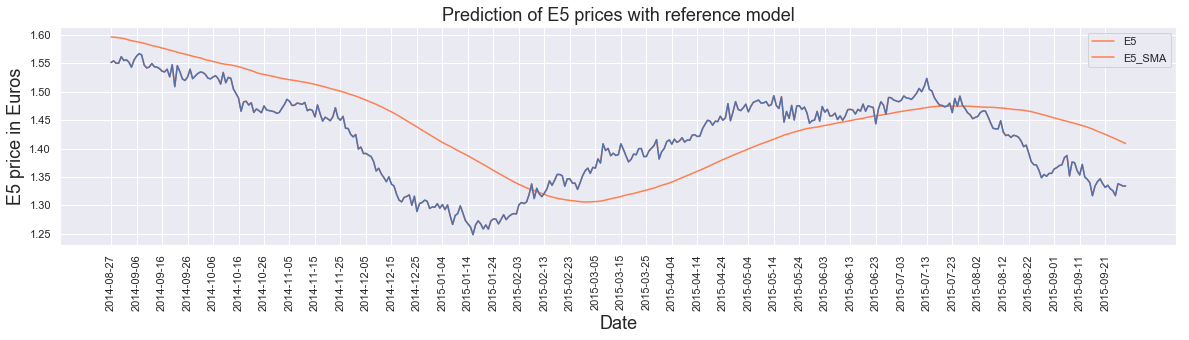

In [2783]:
plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=reference_model["E5"], color="coral", label="E5")
ax = sns.lineplot(data=reference_model["E5_SMA"], color="coral", label="E5_SMA")
ax = sns.lineplot(data=reference_model,x="date",y="E5")
#ax.set_xticklabels(rotation=30)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(reference_model['date']),10)))
#plt.xticks((reference_model['date'].iloc[0],reference_model['date'].iloc[-1],10))
plt.ylabel('E5 price in Euros', fontsize=18)
plt.title('Prediction of E5 prices with reference model', fontsize=18)

Text(0.5, 1.0, 'Prediction of E10 prices with reference model')

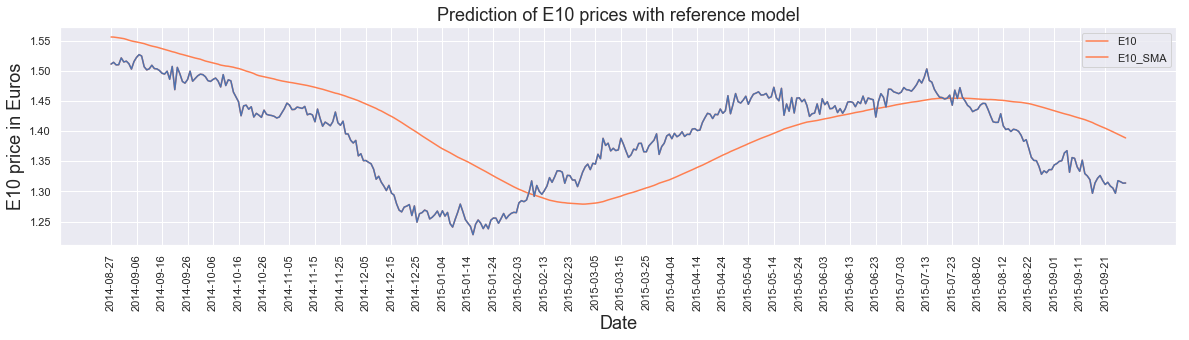

In [2784]:
plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=reference_model["E10"], color="coral", label="E10")
ax = sns.lineplot(data=reference_model["E10_SMA"], color="coral", label="E10_SMA")
ax = sns.lineplot(data=reference_model,x="date",y="E10")
#ax.set_xticklabels(rotation=30)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(reference_model['date']),10)))
#plt.xticks((reference_model['date'].iloc[0],reference_model['date'].iloc[-1],10))
plt.ylabel('E10 price in Euros', fontsize=18)
plt.title('Prediction of E10 prices with reference model', fontsize=18)

Text(0.5, 1.0, 'Prediction of DIESEL prices with reference model')

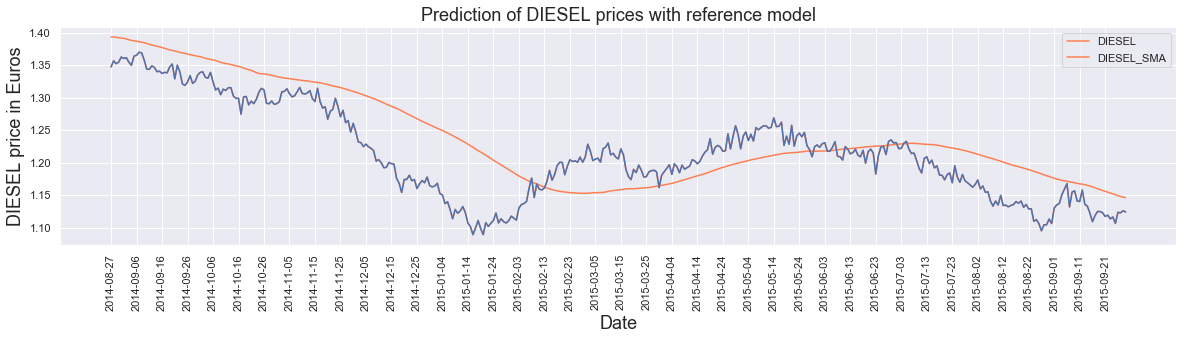

In [2785]:
plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=reference_model["DIESEL"], color="coral", label="DIESEL")
ax = sns.lineplot(data=reference_model["DIESEL_SMA"], color="coral", label="DIESEL_SMA")
ax = sns.lineplot(data=reference_model,x="date",y="DIESEL")
#ax.set_xticklabels(rotation=30)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(reference_model['date']),10)))
#plt.xticks((reference_model['date'].iloc[0],reference_model['date'].iloc[-1],10))
plt.ylabel('DIESEL price in Euros', fontsize=18)
plt.title('Prediction of DIESEL prices with reference model', fontsize=18)

### Calculating Mean Absolute Deviation (MAD)

In [2786]:
reference_model['E5_MAD']=reference_model[['E5','E5_SMA']].mad(axis=1)

In [2787]:
reference_model['E10_MAD']=reference_model[['E10','E10_SMA']].mad(axis=1)
reference_model['DIESEL_MAD']=reference_model[['DIESEL','DIESEL_SMA']].mad(axis=1)

In [2788]:
reference_model.head()

,date,E5,E10,DIESEL,E5_SMA,E10_SMA,DIESEL_SMA,E5_MAD,E10_MAD,DIESEL_MAD
0,2014-08-27,1.551500,1.511500,1.347333,1.596459,1.556459,1.393457,0.022479,0.022479,0.023062
1,2014-08-28,1.554385,1.514385,1.356692,1.596324,1.556324,1.393436,0.020969,0.020969,0.018372
2,2014-08-29,1.550111,1.510111,1.352333,1.595766,1.555766,1.392925,0.022827,0.022827,0.020296
3,2014-08-30,1.550429,1.510429,1.354714,1.595132,1.555132,1.392398,0.022352,0.022352,0.018842
4,2014-08-31,1.561727,1.521727,1.362636,1.594414,1.554414,1.391817,0.016343,0.016343,0.014590


### Calculate Mean Absolute Percentage Error (MAPE)

In [2789]:
def mean_absolute_percentage_error_MAPE(data, y_true='y_true', y_pred='y_pred'):
    # y_true, y_pred = np.array(y_true), np.array(y_pred)
     MAPE = np.mean(np.abs((data[y_true] - data[y_pred]) / data[y_true])) * 100
     return MAPE

In [2790]:
reference_model['E5_MAPE']= reference_model.apply(mean_absolute_percentage_error_MAPE,y_true='E5',y_pred='E5_SMA', axis=1)

In [2791]:
reference_model['E10_MAPE']= reference_model.apply(mean_absolute_percentage_error_MAPE,y_true='E10',y_pred='E10_SMA', axis=1)
reference_model['DIESEL_MAPE']= reference_model.apply(mean_absolute_percentage_error_MAPE,y_true='DIESEL',y_pred='DIESEL_SMA', axis=1)

In [2792]:
reference_model.head()

,date,E5,E10,DIESEL,E5_SMA,E10_SMA,DIESEL_SMA,E5_MAD,E10_MAD,DIESEL_MAD,E5_MAPE,E10_MAPE,DIESEL_MAPE
0,2014-08-27,1.551500,1.511500,1.347333,1.596459,1.556459,1.393457,0.022479,0.022479,0.023062,2.897772,2.974458,3.423301
1,2014-08-28,1.554385,1.514385,1.356692,1.596324,1.556324,1.393436,0.020969,0.020969,0.018372,2.698103,2.769369,2.708313
2,2014-08-29,1.550111,1.510111,1.352333,1.595766,1.555766,1.392925,0.022827,0.022827,0.020296,2.945254,3.023269,3.001587
3,2014-08-30,1.550429,1.510429,1.354714,1.595132,1.555132,1.392398,0.022352,0.022352,0.018842,2.883294,2.959651,2.781693
4,2014-08-31,1.561727,1.521727,1.362636,1.594414,1.554414,1.391817,0.016343,0.016343,0.014590,2.092969,2.147984,2.141478


# Step 2: go with a more complicated model

In [2793]:
#train, test = np.split(data_top100, [int(0.66 * len(data_top100))])
train, test = np.split(data_random3, [int(0.66 * len(data_random3))])

In [2794]:
def facebook_prophet(df,previous):
    m = Prophet(yearly_seasonality=True,daily_seasonality=True)
    m.fit(df)
    future = m.make_future_dataframe(periods = 1)
    forecast = m.predict(future)
    #forcast['E5_previous']=df_e5
    return forecast

In [2795]:
random3_E5_data_set = data_random3.reset_index()
random3_E5_data_set = random3_E5_data_set.rename(columns={'index': 'ds', 'E5': 'y'})
Prophet_E5 = facebook_prophet(random3_E5_data_set, len(train))

In [2796]:
Prophet_E5 = Prophet_E5.rename(columns={'ds': 'date'})
Prophet_E5_concat = pd.concat([Prophet_E5,reference_model],axis=1)

Text(0.5, 1.0, 'Prediction of E5 prices with prophet')

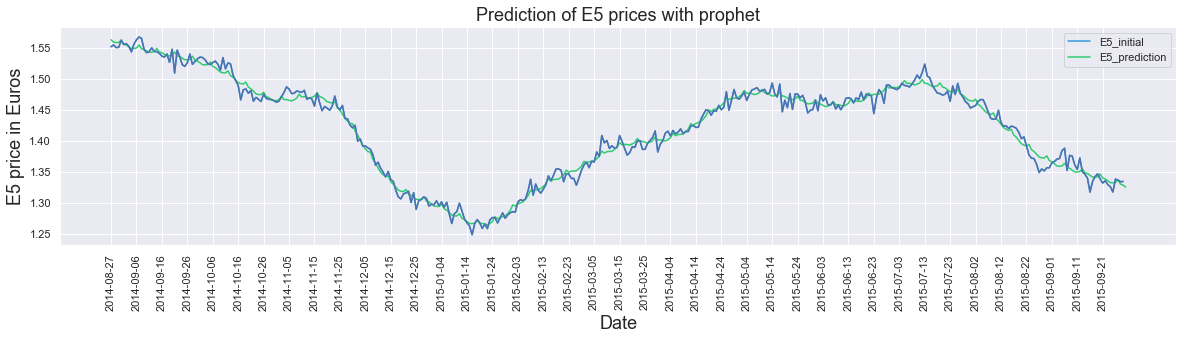

In [2797]:
plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=reference_model["E5"], color="#3498db", label="E5_initial")
ax = sns.lineplot(data=Prophet_E5_concat["yhat"], color="#2ecc71", label="E5_prediction")
ax = sns.lineplot(data=reference_model,x="date",y="E5")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_E5_concat['date']),10)))
plt.ylabel('E5 price in Euros', fontsize=18)
plt.title('Prediction of E5 prices with prophet', fontsize=18)

In [2798]:
random3_E10_data_set = data_random3.reset_index()
random3_E10_data_set = random3_E10_data_set.rename(columns={'index': 'ds', 'E10': 'y'})
Prophet_E10 = facebook_prophet(random3_E10_data_set, len(train))

In [2799]:
Prophet_E10 = Prophet_E10.rename(columns={'ds': 'date'})
Prophet_E10_concat = pd.concat([Prophet_E10,reference_model],axis=1)

Text(0.5, 1.0, 'Prediction of E10 prices with prophet')

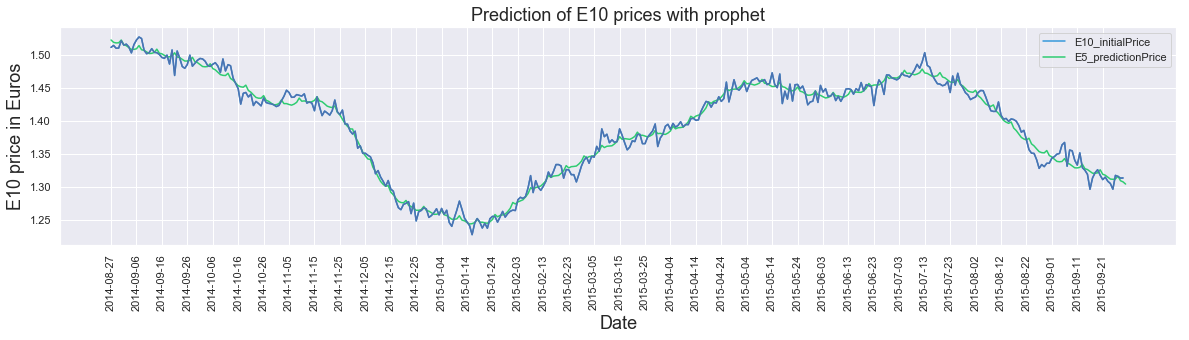

In [2800]:
plt.figure(figsize=(20,4))
ax = sns.lineplot(data=reference_model["E10"], color="#3498db", label="E10_initialPrice")
ax = sns.lineplot(data=Prophet_E10_concat["yhat"], color="#2ecc71", label="E5_predictionPrice")
ax = sns.lineplot(data=reference_model,x="date",y="E10")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_E10_concat['date']),10)))
plt.ylabel('E10 price in Euros', fontsize=18)
plt.title('Prediction of E10 prices with prophet', fontsize=18)

In [2801]:
random3_DIESEL_data_set = data_random3.reset_index()
random3_DIESEL_data_set = random3_DIESEL_data_set.rename(columns={'index': 'ds', 'DIESEL': 'y'})
Prophet_DIESEL = facebook_prophet(random3_DIESEL_data_set, len(train))

In [2802]:
Prophet_DIESEL = Prophet_DIESEL.rename(columns={'ds': 'date'})
Prophet_DIESEL_concat = pd.concat([Prophet_DIESEL,reference_model],axis=1)

Text(0.5, 1.0, 'Prediction of DIESEL prices with prophet')

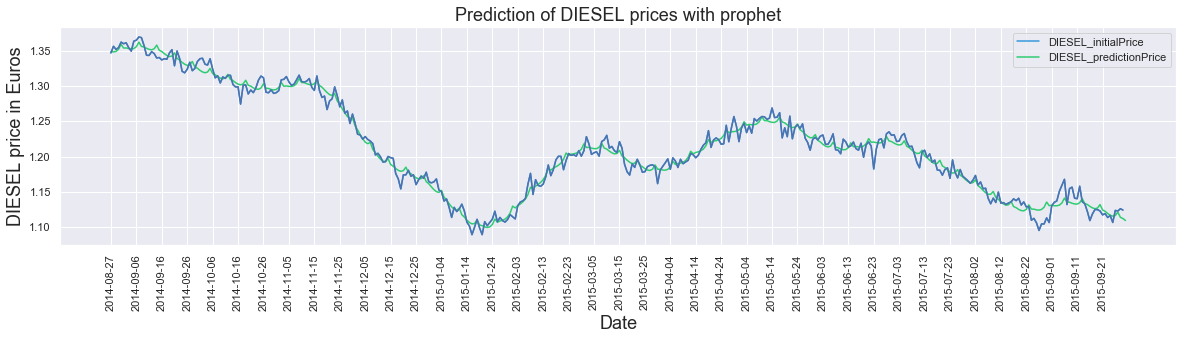

In [2803]:
plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=reference_model["DIESEL"], color="#3498db", label="DIESEL_initialPrice")
ax = sns.lineplot(data=Prophet_DIESEL_concat["yhat"], color="#2ecc71", label="DIESEL_predictionPrice")
ax = sns.lineplot(data=reference_model,x="date",y="DIESEL")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_DIESEL_concat['date']),10)))
plt.ylabel('DIESEL price in Euros', fontsize=18)
plt.title('Prediction of DIESEL prices with prophet', fontsize=18)

### Calculate MAD and MAPE for Prophet Model

In [2804]:
prophet_data = pd.DataFrame()

In [2805]:
# Calculate MAD

prophet_data['E5_MAD_Prophet']=Prophet_E5_concat[['E5','yhat']].mad(axis=1)
prophet_data['E10_MAD_Prophet']=Prophet_E10_concat[['E10','yhat']].mad(axis=1)
prophet_data['DIESEL_MAD_Prophet']=Prophet_DIESEL_concat[['DIESEL','yhat']].mad(axis=1)

In [2806]:
prophet_data.head()

,E5_MAD_Prophet,E10_MAD_Prophet,DIESEL_MAD_Prophet
0,0.005584,0.005582,0.000890
1,0.002270,0.002353,0.003991
2,0.004038,0.004051,0.001443
3,0.003965,0.003996,0.001119
4,0.000389,0.000407,0.001548


In [2807]:
# Calculate MPAE for Prophet

prophet_data['E5_MAPE_Prophet']= Prophet_E5_concat.apply(mean_absolute_percentage_error_MAPE,y_true='E5',y_pred='yhat', axis=1)
prophet_data['E10_MAPE_Prophet']= Prophet_E10_concat.apply(mean_absolute_percentage_error_MAPE,y_true='E10',y_pred='yhat', axis=1)
prophet_data['DIESEL_MAPE_Prophet']= Prophet_DIESEL_concat.apply(mean_absolute_percentage_error_MAPE,y_true='DIESEL',y_pred='yhat', axis=1)

In [2808]:
prophet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
E5_MAD_Prophet         400 non-null float64
E10_MAD_Prophet        400 non-null float64
DIESEL_MAD_Prophet     400 non-null float64
E5_MAPE_Prophet        399 non-null float64
E10_MAPE_Prophet       399 non-null float64
DIESEL_MAPE_Prophet    399 non-null float64
dtypes: float64(6)
memory usage: 18.8 KB


### Compare the prediction result against the trivial reference model, visually on MAD / MAPE

Text(0.5, 1.0, 'Mean Absolute Deviation for Prediction of E5 Prices')

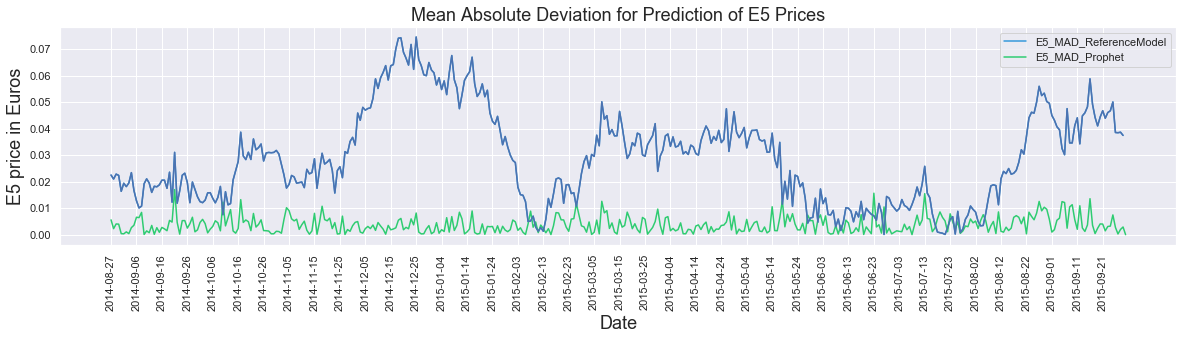

In [2809]:
plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=Prophet_E5_concat["E5_MAD"], color="#3498db", label="E5_MAD_ReferenceModel")
ax = sns.lineplot(data=prophet_data["E5_MAD_Prophet"], color="#2ecc71", label="E5_MAD_Prophet")
ax = sns.lineplot(data=reference_model,x="date",y="E5_MAD")
#ax.set_xticklabels(rotation=30)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_E5_concat['date']),10)))
#plt.xticks((reference_model['date'].iloc[0],reference_model['date'].iloc[-1],10))
plt.ylabel('E5 price in Euros', fontsize=18)
plt.title('Mean Absolute Deviation for Prediction of E5 Prices', fontsize=18)

Text(0.5, 1.0, 'Mean Absolute Deviation for Prediction of E10 Prices')

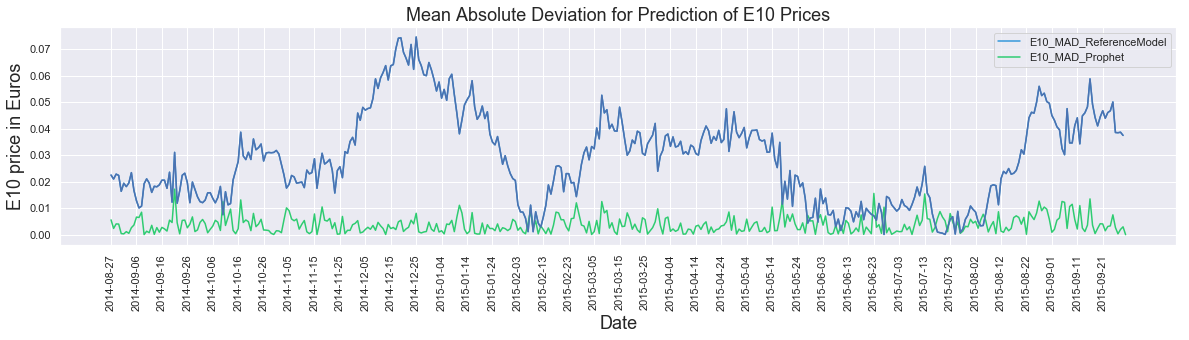

In [2810]:
plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=Prophet_E10_concat["E10_MAD"], color="#3498db", label="E10_MAD_ReferenceModel")
ax = sns.lineplot(data=prophet_data["E10_MAD_Prophet"], color="#2ecc71", label="E10_MAD_Prophet")
ax = sns.lineplot(data=reference_model,x="date",y="E10_MAD")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_E10_concat['date']),10)))
plt.ylabel('E10 price in Euros', fontsize=18)
plt.title('Mean Absolute Deviation for Prediction of E10 Prices', fontsize=18)

Text(0.5, 1.0, 'Mean Absolute Deviation for Prediction of DIESEL Prices')

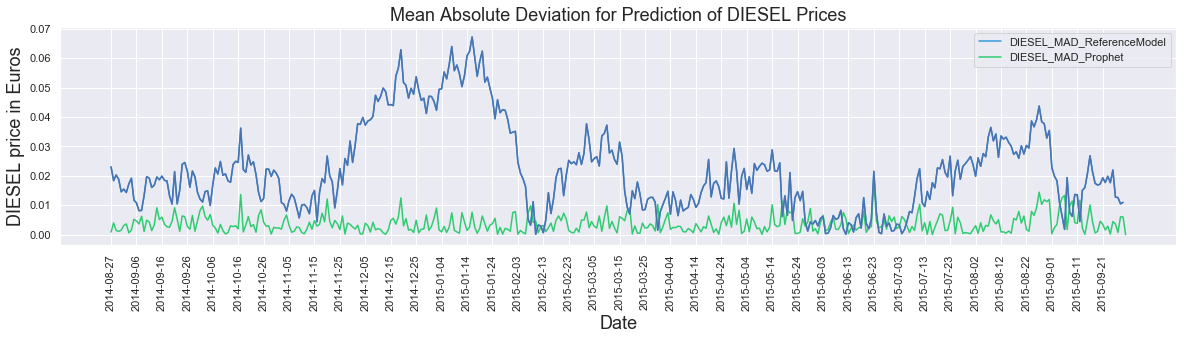

In [2811]:
plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=Prophet_DIESEL_concat["DIESEL_MAD"], color="#3498db", label="DIESEL_MAD_ReferenceModel")
ax = sns.lineplot(data=prophet_data["DIESEL_MAD_Prophet"], color="#2ecc71", label="DIESEL_MAD_Prophet")
ax = sns.lineplot(data=reference_model,x="date",y="DIESEL_MAD")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_DIESEL_concat['date']),10)))
plt.ylabel('DIESEL price in Euros', fontsize=18)
plt.title('Mean Absolute Deviation for Prediction of DIESEL Prices', fontsize=18)

Text(0.5, 1.0, 'Mean Absolute Percentage Error for Prediction of E5 Prices')

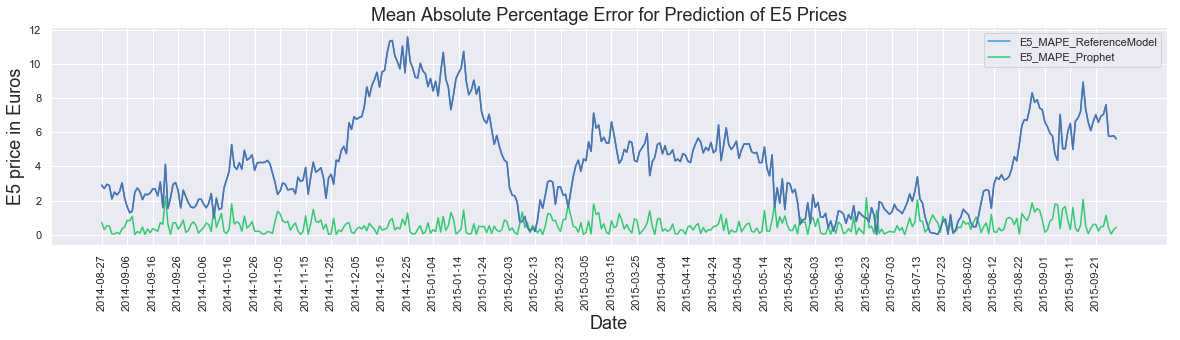

In [2812]:
plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=Prophet_E5_concat["E5_MAPE"], color="#3498db", label="E5_MAPE_ReferenceModel")
ax = sns.lineplot(data=prophet_data["E5_MAPE_Prophet"], color="#2ecc71", label="E5_MAPE_Prophet")
ax = sns.lineplot(data=reference_model,x="date",y="E5_MAPE")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_E5_concat['date']),10)))
plt.ylabel('E5 price in Euros', fontsize=18)
plt.title('Mean Absolute Percentage Error for Prediction of E5 Prices', fontsize=18)

Text(0.5, 1.0, 'Mean Absolute Percentage Error for Prediction of E10 Prices')

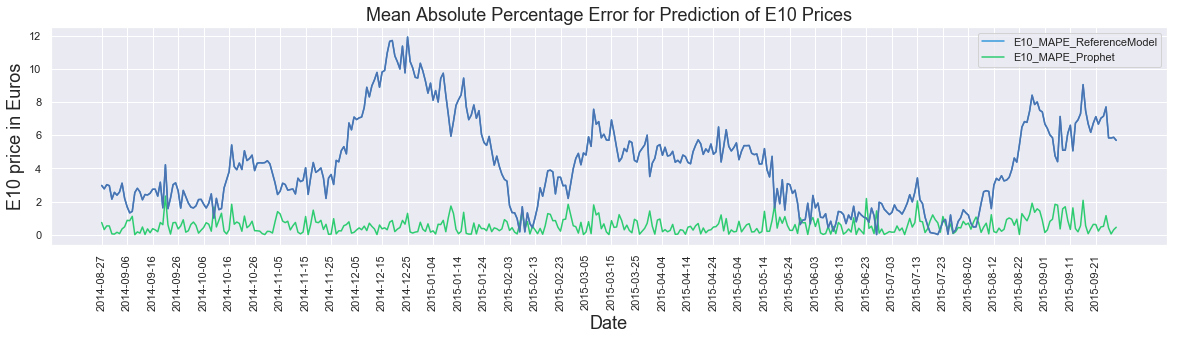

In [2813]:
plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=Prophet_E10_concat["E10_MAPE"], color="#3498db", label="E10_MAPE_ReferenceModel")
ax = sns.lineplot(data=prophet_data["E10_MAPE_Prophet"], color="#2ecc71", label="E10_MAPE_Prophet")
ax = sns.lineplot(data=reference_model,x="date",y="E10_MAPE")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_E10_concat['date']),10)))
plt.ylabel('E10 price in Euros', fontsize=18)
plt.title('Mean Absolute Percentage Error for Prediction of E10 Prices', fontsize=18)

Text(0.5, 1.0, 'Mean Absolute Percentage Error for Prediction of DIESEL Prices')

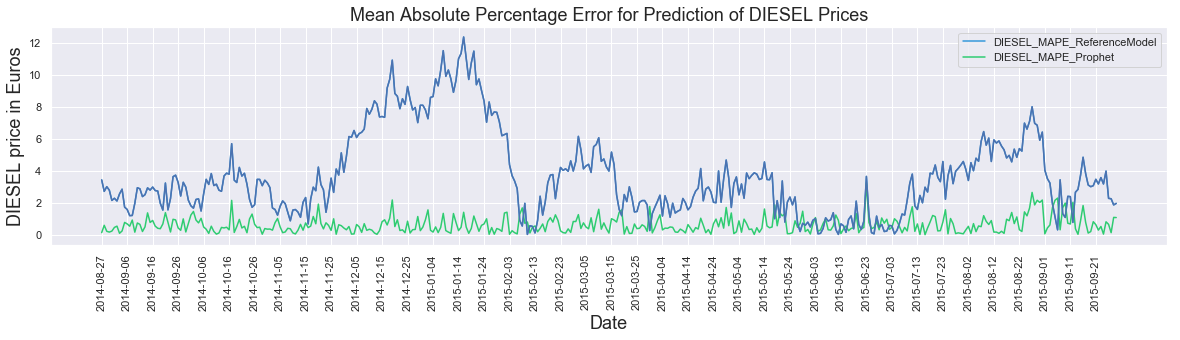

In [2814]:
plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=Prophet_DIESEL_concat["DIESEL_MAPE"], color="#3498db", label="DIESEL_MAPE_ReferenceModel")
ax = sns.lineplot(data=prophet_data["DIESEL_MAPE_Prophet"], color="#2ecc71", label="DIESEL_MAPE_Prophet")
ax = sns.lineplot(data=reference_model,x="date",y="DIESEL_MAPE")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_DIESEL_concat['date']),10)))
plt.ylabel('DIESEL price in Euros', fontsize=18)
plt.title('Mean Absolute Percentage Error for Prediction of DIESEL Prices', fontsize=18)

## Step 3: Do the comparison on the full 100 data set, are the results for e5, e10 and diesel

#### Spliting the data (two third of the data for training and one third for evaluation of the model)

In [2815]:
# getting   of length of training data

data_training_length_100 = int(len(data_top100) * 0.6667)

In [2816]:
# dividing training data and testing data

data_training_100 = data_top100[0:data_training_length_100]
data_testing_100 = data_top100[data_training_length_100:len(data_top100)]

In [2817]:
reference_model_100 = data_top100

In [2818]:
# Calculating SMA for E5, E10, DIESEL

reference_model_100['E5_SMA'] = SMA(reference_model_100['E5'])
reference_model_100['E10_SMA'] = SMA(reference_model_100['E10'])
reference_model_100['DIESEL_SMA'] = SMA(reference_model_100['DIESEL'])

In [2819]:
reference_model_100.dropna(inplace=True)
reference_model_100 = reference_model_100.reset_index()
reference_model_100 = reference_model_100.rename(columns={'index': 'date'})
reference_model_100['date'] = reference_model_100['date'].apply(lambda x: x.strftime("%Y-%m-%d"))

In [2820]:
# Predicting E5 price by prophet

top100_E5_data_set = data_top100.reset_index()
top100_E5_data_set = top100_E5_data_set.rename(columns={'index': 'ds', 'E5': 'y'})
Prophet_E5_100 = facebook_prophet(top100_E5_data_set, len(data_training_100))

In [2821]:
Prophet_E5_100 = Prophet_E5_100.rename(columns={'ds': 'date'})
Prophet_E5_concat_100 = pd.concat([Prophet_E5_100,reference_model_100],axis=1)

Text(0.5, 1.0, 'Comparision of E5 prices')

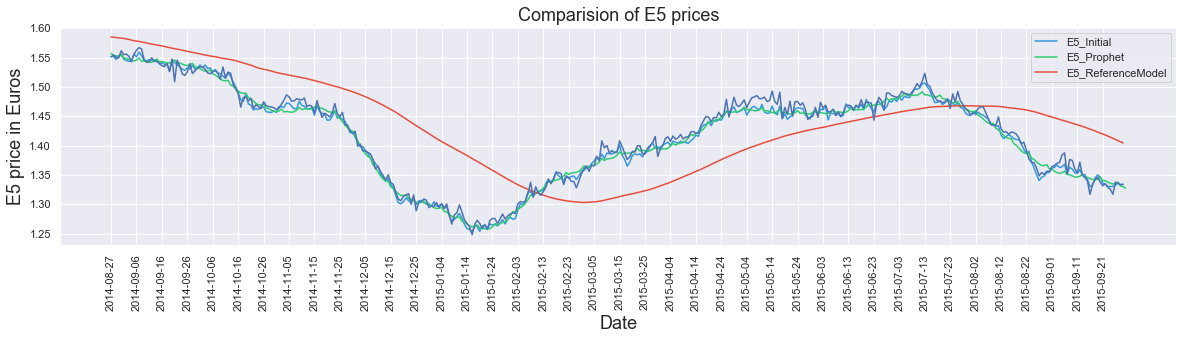

In [2822]:
# Comparision Graph of E5 Prices

plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=Prophet_E5_concat_100["E5"], color="#3498db", label="E5_Initial")
ax = sns.lineplot(data=Prophet_E5_concat_100["yhat"], color="#2ecc71", label="E5_Prophet")
ax = sns.lineplot(data=Prophet_E5_concat_100["E5_SMA"], color="#e74c3c", label="E5_ReferenceModel")
ax = sns.lineplot(data=reference_model,x="date",y="E5")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_E5_concat_100['date']),10)))
plt.ylabel('E5 price in Euros', fontsize=18)
plt.title('Comparision of E5 prices', fontsize=18)

In [2823]:
# Predicting E10 price by prophet

top100_E10_data_set = data_top100.reset_index()
top100_E10_data_set = top100_E10_data_set.rename(columns={'index': 'ds', 'E10': 'y'})
Prophet_E10_100 = facebook_prophet(top100_E10_data_set, len(data_training_100))

In [2824]:
Prophet_E10_100 = Prophet_E10_100.rename(columns={'ds': 'date'})
Prophet_E10_concat_100 = pd.concat([Prophet_E10_100,reference_model_100],axis=1)

Text(0.5, 1.0, 'Comparision of E10 prices')

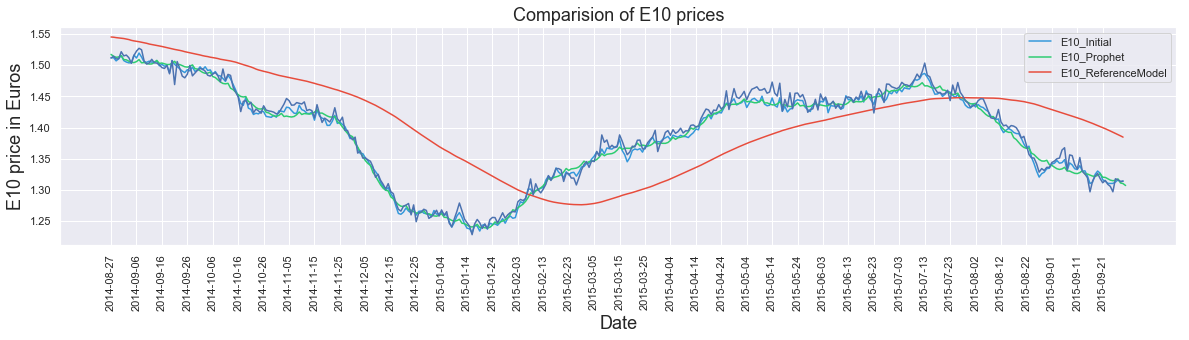

In [2825]:
# Comparision Graph of E10 Prices

plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=Prophet_E10_concat_100["E10"], color="#3498db", label="E10_Initial")
ax = sns.lineplot(data=Prophet_E10_concat_100["yhat"], color="#2ecc71", label="E10_Prophet")
ax = sns.lineplot(data=Prophet_E10_concat_100["E10_SMA"], color="#e74c3c", label="E10_ReferenceModel")
ax = sns.lineplot(data=reference_model,x="date",y="E10")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_E10_concat_100['date']),10)))
plt.ylabel('E10 price in Euros', fontsize=18)
plt.title('Comparision of E10 prices', fontsize=18)

In [2826]:
# Predicting E10 price by prophet

top100_DIESEL_data_set = data_top100.reset_index()
top100_DIESEL_data_set = top100_DIESEL_data_set.rename(columns={'index': 'ds', 'DIESEL': 'y'})
Prophet_DIESEL_100 = facebook_prophet(top100_DIESEL_data_set, len(data_training_100))

In [2827]:
Prophet_DIESEL_100 = Prophet_DIESEL_100.rename(columns={'ds': 'date'})
Prophet_DIESEL_concat_100 = pd.concat([Prophet_DIESEL_100,reference_model_100],axis=1)

Text(0.5, 1.0, 'Comparision of DIESEL prices')

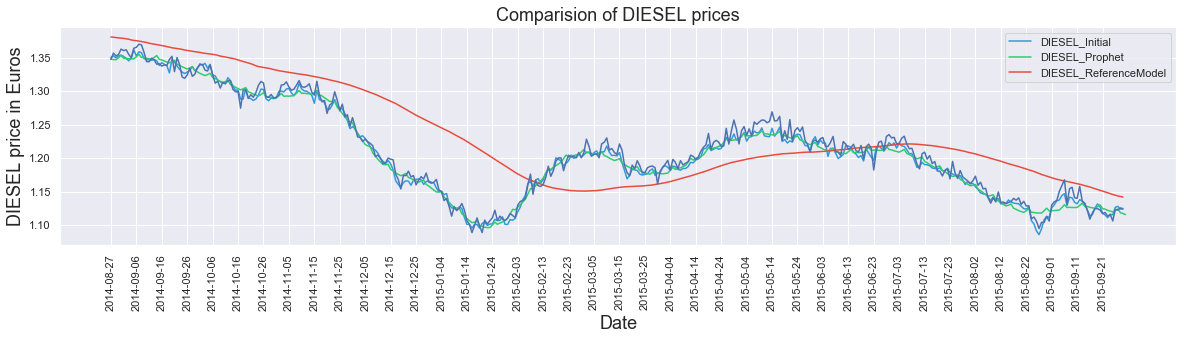

In [2828]:
# Comparision Graph of DIESEL Prices

plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=Prophet_DIESEL_concat_100["DIESEL"], color="#3498db", label="DIESEL_Initial")
ax = sns.lineplot(data=Prophet_DIESEL_concat_100["yhat"], color="#2ecc71", label="DIESEL_Prophet")
ax = sns.lineplot(data=Prophet_DIESEL_concat_100["DIESEL_SMA"], color="#e74c3c", label="DIESEL_ReferenceModel")
ax = sns.lineplot(data=reference_model,x="date",y="DIESEL")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_DIESEL_concat_100['date']),10)))
plt.ylabel('DIESEL price in Euros', fontsize=18)
plt.title('Comparision of DIESEL prices', fontsize=18)

#### Compairing MAD from Reference Model and Prophet

In [2829]:
reference_model_100['E5_MAD']=reference_model_100[['E5','E5_SMA']].mad(axis=1)
reference_model_100['E10_MAD']=reference_model_100[['E10','E10_SMA']].mad(axis=1)
reference_model_100['DIESEL_MAD']=reference_model_100[['DIESEL','DIESEL_SMA']].mad(axis=1)

In [2830]:
prophet_data_100 = pd.DataFrame()

In [2831]:
# Calculate MAD

prophet_data_100['E5_MAD_Prophet']=Prophet_E5_concat_100[['E5','yhat']].mad(axis=1)
prophet_data_100['E10_MAD_Prophet']=Prophet_E10_concat_100[['E10','yhat']].mad(axis=1)
prophet_data_100['DIESEL_MAD_Prophet']=Prophet_DIESEL_concat_100[['DIESEL','yhat']].mad(axis=1)

Text(0.5, 1.0, 'Mean Absolute Deviation for Prediction of E5 Prices')

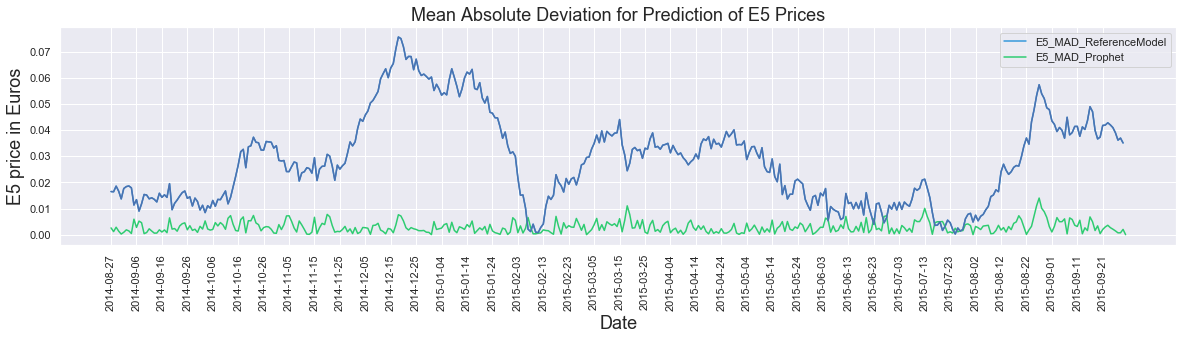

In [2832]:
# Graph to compare MAD from Reference model and prophet for E5

plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=reference_model_100["E5_MAD"], color="#3498db", label="E5_MAD_ReferenceModel")
ax = sns.lineplot(data=prophet_data_100["E5_MAD_Prophet"], color="#2ecc71", label="E5_MAD_Prophet")
ax = sns.lineplot(data=reference_model_100,x="date",y="E5_MAD")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_E5_concat_100['date']),10)))
plt.ylabel('E5 price in Euros', fontsize=18)
plt.title('Mean Absolute Deviation for Prediction of E5 Prices', fontsize=18)

Text(0.5, 1.0, 'Mean Absolute Deviation for Prediction of E10 Prices')

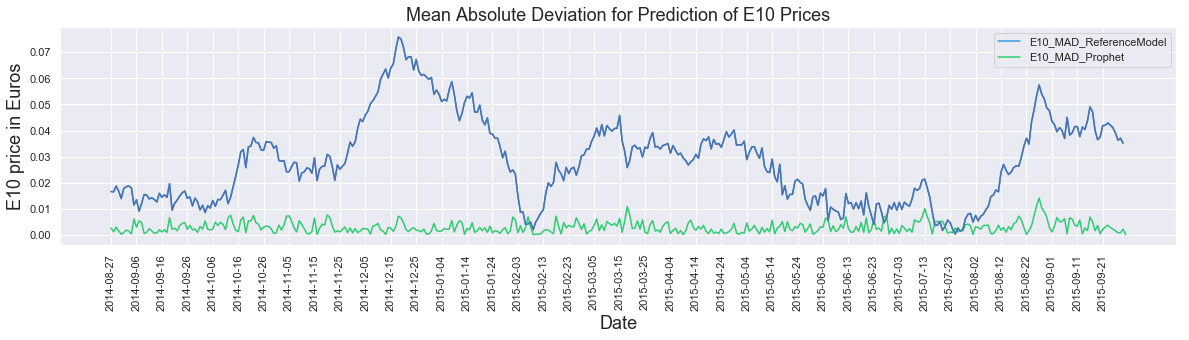

In [2833]:
# Graph to compare MAD from Reference model and prophet for E10

plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=reference_model_100["E10_MAD"], color="#3498db", label="E10_MAD_ReferenceModel")
ax = sns.lineplot(data=prophet_data_100["E10_MAD_Prophet"], color="#2ecc71", label="E10_MAD_Prophet")
ax = sns.lineplot(data=reference_model_100,x="date",y="E10_MAD")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_E10_concat_100['date']),10)))
plt.ylabel('E10 price in Euros', fontsize=18)
plt.title('Mean Absolute Deviation for Prediction of E10 Prices', fontsize=18)

Text(0.5, 1.0, 'Mean Absolute Deviation for Prediction of DIESEL Prices')

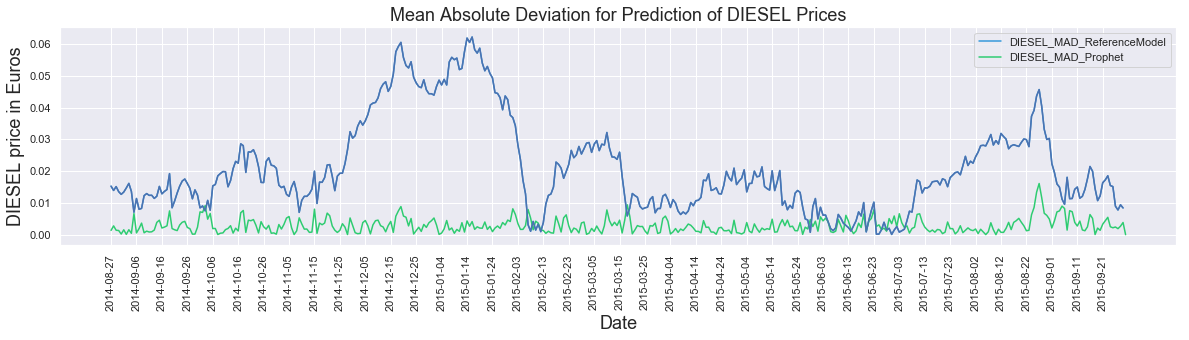

In [2834]:
# Graph to compare MAD from Reference model and prophet for DIESEL

plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=reference_model_100["DIESEL_MAD"], color="#3498db", label="DIESEL_MAD_ReferenceModel")
ax = sns.lineplot(data=prophet_data_100["DIESEL_MAD_Prophet"], color="#2ecc71", label="DIESEL_MAD_Prophet")
ax = sns.lineplot(data=reference_model_100,x="date",y="DIESEL_MAD")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_DIESEL_concat_100['date']),10)))
plt.ylabel('DIESEL price in Euros', fontsize=18)
plt.title('Mean Absolute Deviation for Prediction of DIESEL Prices', fontsize=18)

#### Compairing MAPE from Reference Model and Prophet

In [2835]:
# Calculating MAPE for Reference Model

reference_model_100['E5_MAPE']= reference_model_100.apply(mean_absolute_percentage_error_MAPE,y_true='E5',y_pred='E5_SMA', axis=1)
reference_model_100['E10_MAPE']= reference_model_100.apply(mean_absolute_percentage_error_MAPE,y_true='E10',y_pred='E10_SMA', axis=1)
reference_model_100['DIESEL_MAPE']= reference_model_100.apply(mean_absolute_percentage_error_MAPE,y_true='DIESEL',y_pred='DIESEL_SMA', axis=1)

In [2836]:
prophet_data_100['E5_MAPE_Prophet']= Prophet_E5_concat_100.apply(mean_absolute_percentage_error_MAPE,y_true='E5',y_pred='yhat', axis=1)
prophet_data_100['E10_MAPE_Prophet']= Prophet_E10_concat_100.apply(mean_absolute_percentage_error_MAPE,y_true='E10',y_pred='yhat', axis=1)
prophet_data_100['DIESEL_MAPE_Prophet']= Prophet_DIESEL_concat_100.apply(mean_absolute_percentage_error_MAPE,y_true='DIESEL',y_pred='yhat', axis=1)

Text(0.5, 1.0, 'Mean Absolute Percentage Error for Prediction of E5 Prices')

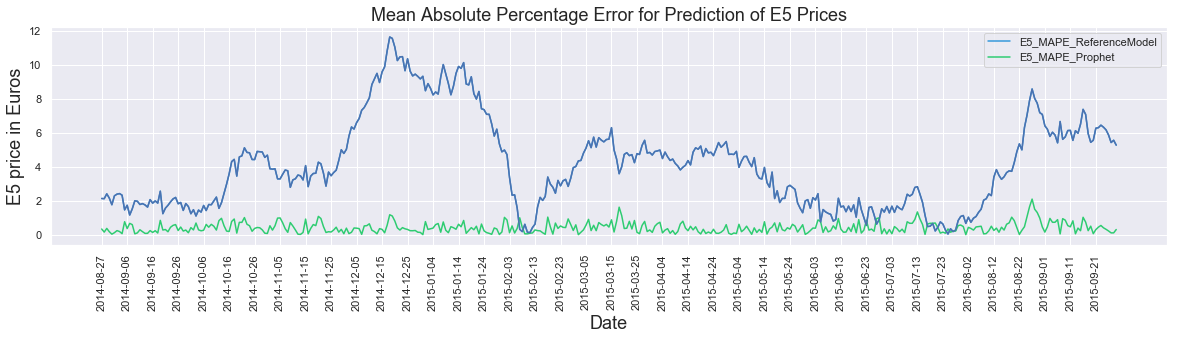

In [2837]:
# Graph to compare MAPE from Reference model and prophet for E5

plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=reference_model_100["E5_MAPE"], color="#3498db", label="E5_MAPE_ReferenceModel")
ax = sns.lineplot(data=prophet_data_100["E5_MAPE_Prophet"], color="#2ecc71", label="E5_MAPE_Prophet")
ax = sns.lineplot(data=reference_model_100,x="date",y="E5_MAPE")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_E5_concat_100['date']),10)))
plt.ylabel('E5 price in Euros', fontsize=18)
plt.title('Mean Absolute Percentage Error for Prediction of E5 Prices', fontsize=18)

Text(0.5, 1.0, 'Mean Absolute Percentage Error for Prediction of E10 Prices')

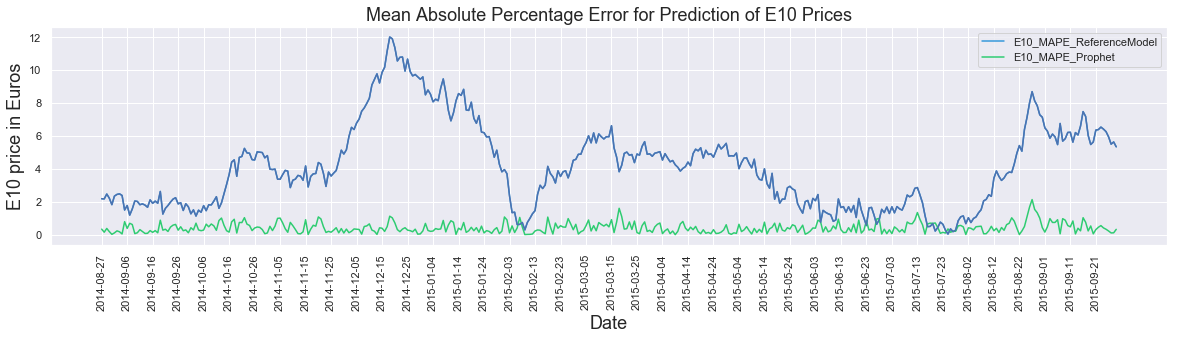

In [2838]:
# Graph to compare MAPE from Reference model and prophet for E10

plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=reference_model_100["E10_MAPE"], color="#3498db", label="E10_MAPE_ReferenceModel")
ax = sns.lineplot(data=prophet_data_100["E10_MAPE_Prophet"], color="#2ecc71", label="E10_MAPE_Prophet")
ax = sns.lineplot(data=reference_model_100,x="date",y="E10_MAPE")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_E10_concat_100['date']),10)))
plt.ylabel('E10 price in Euros', fontsize=18)
plt.title('Mean Absolute Percentage Error for Prediction of E10 Prices', fontsize=18)

Text(0.5, 1.0, 'Mean Absolute Percentage Error for Prediction of DIESEL Prices')

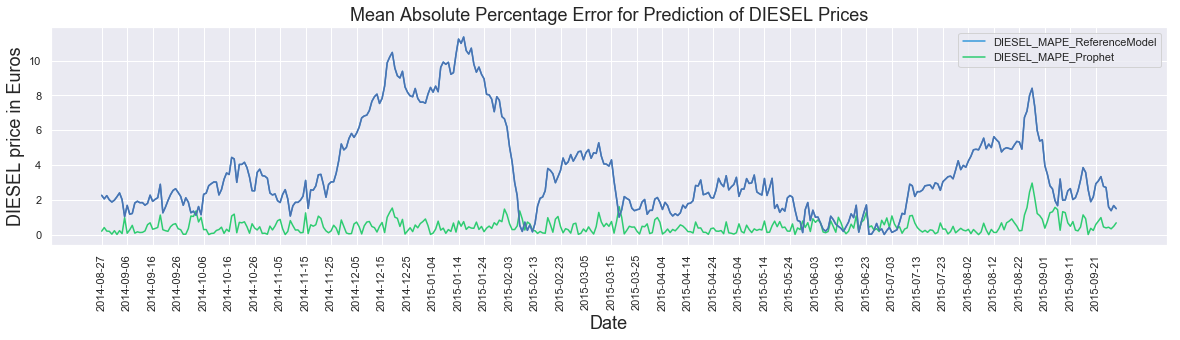

In [2839]:
# Graph to compare MAPE from Reference model and prophet for DIESEL

plt.figure(figsize=(20, 4))
ax = sns.lineplot(data=reference_model_100["DIESEL_MAPE"], color="#3498db", label="DIESEL_MAPE_ReferenceModel")
ax = sns.lineplot(data=prophet_data_100["DIESEL_MAPE_Prophet"], color="#2ecc71", label="DIESEL_MAPE_Prophet")
ax = sns.lineplot(data=reference_model_100,x="date",y="DIESEL_MAPE")
ax=plt.xticks(rotation=90)
plt.xlabel('Date', fontsize=18)
plt.xticks((np.arange(0,len(Prophet_DIESEL_concat_100['date']),10)))
plt.ylabel('DIESEL price in Euros', fontsize=18)
plt.title('Mean Absolute Percentage Error for Prediction of DIESEL Prices', fontsize=18)